# Homework - Vertical FL and Generative Modeling
Vertical federated learning (VFL) and generative modeling are two techniques for privacy preservation. The former enables collaborative training across vertically partitioned data. At the same time, generative modeling creates synthetic data as an alternative to using real sensitive data. In this assignment, you'll further explore some factors affecting model performance in VFL and how it can be bridged with generative modeling. 



# Instructions

Submit your assignment as a Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.

## Question 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **5** random feature permutations and plot the training loss. Report whether shuffling features significantly affects the convergence rates and the reasoning behind it.

Scoring:
- _(1 point)_ Create 5 feature permutations (shuffling done before one-hot encoding) with seeded Python/NumPy random functions and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) the permutations have on the loss and explain the observed pattern.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler


class BottomModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(BottomModel, self).__init__()
        self.local_out_dim = out_feat
        self.fc1 = nn.Linear(in_feat, out_feat)
        self.fc2 = nn.Linear(out_feat, out_feat)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.dropout(self.act(self.fc2(x)))


class TopModel(nn.Module):
    def __init__(self, local_models, n_outs):
        super(TopModel, self).__init__()
        self.in_size = sum(
            [local_models[i].local_out_dim for i in range(len(local_models))]
        )
        self.fc1 = nn.Linear(self.in_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        concat_outs = torch.cat(x, dim=1)
        x = self.act(self.fc1(concat_outs))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.dropout(x)


class VFLNetwork(nn.Module):
    def __init__(self, local_models, n_outs):
        super(VFLNetwork, self).__init__()
        self.num_cli = None
        self.cli_features = None
        self.bottom_models = local_models
        self.top_model = TopModel(self.bottom_models, n_outs)
        self.optimizer = optim.AdamW(self.parameters())
        self.criterion = nn.CrossEntropyLoss()

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, y):
        train_losses = []
        self.num_cli = n_cli
        self.cli_features = cli_features
        x = x.astype("float32")
        y = y.astype("float32")
        x_train = [torch.tensor(x[feats].values) for feats in cli_features]
        y_train = torch.tensor(y.values)
        num_batches = (
            len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
        )
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            correct = 0.0
            total = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = [x[int(minibatch * batch_sz) :] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz) :]
                else:
                    x_minibatch = [
                        x[int(minibatch * batch_sz) : int((minibatch + 1) * batch_sz)]
                        for x in x_train
                    ]
                    y_minibatch = y_train[
                        int(minibatch * batch_sz) : int((minibatch + 1) * batch_sz)
                    ]

                outs = self.forward(x_minibatch)
                pred = torch.argmax(outs, dim=1)
                actual = torch.argmax(y_minibatch, dim=1)
                correct += torch.sum((pred == actual))
                total += len(actual)
                loss = self.criterion(outs, y_minibatch)
                total_loss += loss
                loss.backward()
                self.optimizer.step()

            train_losses.append(total_loss.detach().numpy() / num_batches)
            print(
                f"Epoch: {epoch} Train accuracy: {correct * 100 / total:.2f}% Loss: {train_losses[-1]:.3f}"
            )

        return train_losses

    def forward(self, x):
        local_outs = [
            self.bottom_models[i](x[i]) for i in range(len(self.bottom_models))
        ]
        return self.top_model(local_outs)

    def test(self, x, y):
        x = x.astype("float32")
        y = y.astype("float32")
        x_test = [torch.tensor(x[feats].values) for feats in self.cli_features]
        y_test = torch.tensor(y.values)
        with torch.no_grad():
            outs = self.forward(x_test)
            preds = torch.argmax(outs, dim=1)
            actual = torch.argmax(y_test, dim=1)
            accuracy = torch.sum((preds == actual)) / len(actual)
            loss = self.criterion(outs, y_test)
            return accuracy, loss

In [2]:
import seaborn as sns


def shuffle_features(columns):
    shuffled_features = np.random.permutation(
        columns[:-1]
    ).tolist()  # random feature permutation
    shuffled_features.append(columns[-1])
    return shuffled_features


def greedy_partition(num_clients, num_features):
    features_per_client = [0] * num_clients
    remaining_features = num_features

    # Assign features to clients greedily
    for i in range(num_clients - 1):
        features_per_client[i] = min(
            remaining_features // (num_clients - i), num_features
        )
        remaining_features -= features_per_client[i]

    # Assign the remaining features to the last client
    features_per_client[-1] = remaining_features
    print(f"Features per client: {features_per_client}")
    return features_per_client


def preprocess_data(num_clients, np_seed=42, shuffle=False, greedy=False):
    torch.manual_seed(42)
    np.random.seed(np_seed)
    df = pd.read_csv("heart-dataset/heart.csv")
    categorical_cols = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
    numerical_cols = ["age", "trestbps", "chol", "thalach", "oldpeak"]
    df[numerical_cols] = MinMaxScaler().fit_transform(
        df[numerical_cols]
    )  # scale numerical features for effective learning

    if shuffle:
        shuffled_features = shuffle_features(df.columns)
        df = df[shuffled_features]

    encoded_df = pd.get_dummies(
        df, columns=categorical_cols
    )  # convert categorical features to one-hot embeddings
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[["target"]], columns=["target"])

    if greedy:
        features_per_client = greedy_partition(num_clients, len(df.columns) - 1)
    else:
        features_per_client = (num_clients - 1) * [
            (len(df.columns) - 1) // num_clients
        ]  # "equally" partition the features
        features_per_client.append(len(df.columns) - 1 - sum(features_per_client))

    features_per_client = np.array(features_per_client)
    all_feature_names = list(df.columns)
    all_feature_names.pop()
    client_feature_names = []
    csum_features_per_client = np.cumsum(features_per_client)
    encoded_df_feature_names = list(X.columns)
    start_index = 0
    end_index = 0
    for num_feats in features_per_client:
        feat_names = all_feature_names[start_index : start_index + num_feats]
        client_feature_names.append(feat_names)
        start_index = start_index + num_feats

    for i in range(len(client_feature_names)):
        updated_names = []
        for column_name in client_feature_names[i]:
            if column_name not in categorical_cols:
                updated_names.append(column_name)
            else:
                for name in encoded_df_feature_names:
                    if "_" in name and column_name in name:
                        updated_names.append(name)

        client_feature_names[i] = updated_names

    return X, Y, client_feature_names


def define_model(client_feature_names):
    # model architecture hyperparameters
    outs_per_client = 2
    bottom_models = [
        BottomModel(len(in_feats), outs_per_client * len(in_feats))
        for in_feats in client_feature_names
    ]
    final_out_dims = 2
    Network = VFLNetwork(bottom_models, final_out_dims)
    return Network


def train_model(
    X,
    Y,
    Network,
    num_clients,
    epochs,
    batch_size,
    train_test_thresh,
    client_feature_names,
):
    # Training configurations
    X_train, X_test = (
        X.loc[: int(train_test_thresh * len(X))],
        X.loc[int(train_test_thresh * len(X)) + 1 :],
    )
    Y_train, Y_test = (
        Y.loc[: int(train_test_thresh * len(Y))],
        Y.loc[int(train_test_thresh * len(Y)) + 1 :],
    )
    train_losses = Network.train_with_settings(
        epochs, batch_size, num_clients, client_feature_names, X_train, Y_train
    )

    accuracy, loss = Network.test(X_test, Y_test)
    print(f"Test accuracy: {accuracy * 100:.2f}%")

    return train_losses


def plot_losses(epochs, losses, label, num):
    ax = sns.lineplot(x=range(epochs), y=losses, seed=0, label=f"{label}: {num}")
    ax.set(xlabel="Epoch", ylabel="Loss")

NumPy seed: 12
Features for each client:
Client 1: ['slope_0', 'slope_1', 'slope_2', 'fbs_0', 'fbs_1', 'oldpeak']
Client 2: ['exang_0', 'exang_1', 'age', 'chol']
Client 3: ['thalach', 'trestbps', 'cp_0', 'cp_1', 'cp_2', 'cp_3']
Client 4: ['sex_0', 'sex_1', 'restecg_0', 'restecg_1', 'restecg_2', 'thal_0', 'thal_1', 'thal_2', 'thal_3', 'ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4']
Epoch: 0 Train accuracy: 59.07% Loss: 0.687
Epoch: 1 Train accuracy: 67.97% Loss: 0.642
Epoch: 2 Train accuracy: 76.25% Loss: 0.544
Epoch: 3 Train accuracy: 70.52% Loss: 0.594
Epoch: 4 Train accuracy: 68.21% Loss: 0.636
Epoch: 5 Train accuracy: 66.50% Loss: 0.648
Epoch: 6 Train accuracy: 66.75% Loss: 0.613
Epoch: 7 Train accuracy: 72.35% Loss: 0.575
Epoch: 8 Train accuracy: 77.95% Loss: 0.538
Epoch: 9 Train accuracy: 78.20% Loss: 0.473
Epoch: 10 Train accuracy: 81.61% Loss: 0.464
Epoch: 11 Train accuracy: 79.66% Loss: 0.466
Epoch: 12 Train accuracy: 78.32% Loss: 0.509
Epoch: 13 Train accuracy: 79.66% Loss: 0.467
Epoc

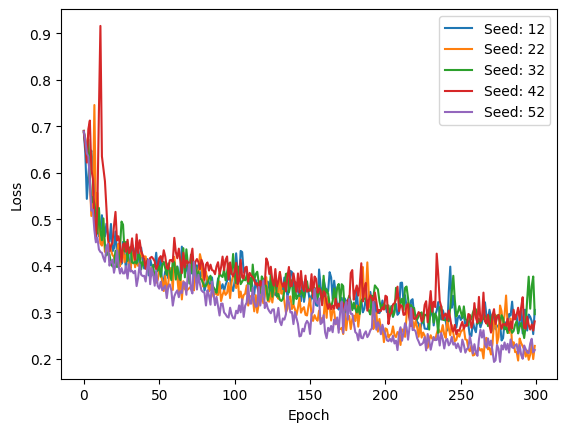

In [3]:
NUM_CLIENTS = 4
EPOCHS = 300
BATCH_SIZE = 64
TRAIN_TEST_THRESH = 0.8

np_seeds = [12, 22, 32, 42, 52]

for np_seed in np_seeds:
    print(f"NumPy seed: {np_seed}")
    X, Y, client_feature_names = preprocess_data(
        NUM_CLIENTS, np_seed=np_seed, shuffle=True
    )

    print("Features for each client:")
    for i, f in enumerate(client_feature_names, 1):
        print(f"Client {i}: {f}")

    Network = define_model(client_feature_names)
    train_losses = train_model(
        X,
        Y,
        Network,
        NUM_CLIENTS,
        EPOCHS,
        BATCH_SIZE,
        TRAIN_TEST_THRESH,
        client_feature_names,
    )
    plot_losses(EPOCHS, train_losses, "Seed", np_seed)
    print()

According to the experiments, the shuffled features (different seeds) may significantly affect the convergence rates. This is because different feature permutations will result in different feature distributions for each client during training. Besides, shuffling features might enable the model to learn more robust representations of data as each client holds different combination of features and some of the features might be correlated to each other. As you can see from the plot, seed 22 (orange) and 52 (purple) converge faster compared to others. On the other hand, all of them observed high variance, especially seed 42 (red). 

## Question 2: Scaling clients in VFL (4 points)

With the same template code, experiment with how increasing the number of clients affects model performance. Plot the training loss with 2, 4, and 8 clients. Try a greedy partition for the features, with the remaining extra features assigned to the last client. For example, with 14 features and three clients, assign four features to clients 1 and 2 and six to client 3. Report your reasoning for the observed output.

Scoring:
- _(1 point)_ Create the greedily-partitioned feature splits for the requested client counts (use the default ordering in the dataset) and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

Number of clients: 2
Features per client: [6, 7]
Epoch: 0 Train accuracy: 56.88% Loss: 0.685
Epoch: 1 Train accuracy: 62.48% Loss: 0.655
Epoch: 2 Train accuracy: 71.62% Loss: 0.595
Epoch: 3 Train accuracy: 69.79% Loss: 0.566
Epoch: 4 Train accuracy: 63.95% Loss: 0.659
Epoch: 5 Train accuracy: 80.51% Loss: 0.484
Epoch: 6 Train accuracy: 77.22% Loss: 0.505
Epoch: 7 Train accuracy: 81.24% Loss: 0.458
Epoch: 8 Train accuracy: 84.04% Loss: 0.431
Epoch: 9 Train accuracy: 81.49% Loss: 0.441
Epoch: 10 Train accuracy: 82.10% Loss: 0.419
Epoch: 11 Train accuracy: 84.77% Loss: 0.396
Epoch: 12 Train accuracy: 83.19% Loss: 0.407
Epoch: 13 Train accuracy: 84.53% Loss: 0.387
Epoch: 14 Train accuracy: 86.11% Loss: 0.371
Epoch: 15 Train accuracy: 83.43% Loss: 0.386
Epoch: 16 Train accuracy: 85.02% Loss: 0.380
Epoch: 17 Train accuracy: 84.29% Loss: 0.386
Epoch: 18 Train accuracy: 84.77% Loss: 0.364
Epoch: 19 Train accuracy: 84.90% Loss: 0.392
Epoch: 20 Train accuracy: 83.43% Loss: 0.409
Epoch: 21 Train 

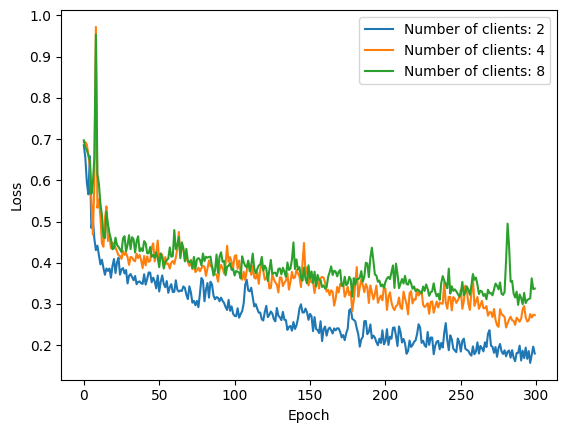

In [4]:
EPOCHS = 300
BATCH_SIZE = 64
TRAIN_TEST_THRESH = 0.8

num_clients = [2, 4, 8]

for nc in num_clients:
    print(f"Number of clients: {nc}")
    X, Y, client_feature_names = preprocess_data(nc, greedy=True)
    Network = define_model(client_feature_names)
    train_losses = train_model(
        X,
        Y,
        Network,
        nc,
        EPOCHS,
        BATCH_SIZE,
        TRAIN_TEST_THRESH,
        client_feature_names,
    )
    plot_losses(EPOCHS, train_losses, "Number of clients", nc)
    print()

By adding more clients, smaller subset of features will be partitioned to each client. Hence, the distribution of features across clients will influence the convergence and loss. This is because the model will learn faster when each client owns a larger subset of features (smaller number of clients). According to the graph, smaller number of clients (larger subset of features) achieved smaller loss values compared to others. Besides, larger number of clients will result in a higher variance of loss.

## Question 3: Bridging VFL and generative modeling (8 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. In this regard, combine VFL with variational autoencoders (VAEs) by following the architecture shown in the figure below. Each client uses a local network, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another MLP. Code the necessary components using the templates from [lab-vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb) and [generative_modeling.py](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/generative_modeling.py). Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features similarly to the discriminative model VFL lab.
- _(2 points)_ Define the input & output MLP networks to be used by clients.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, printing the loss at every epoch.

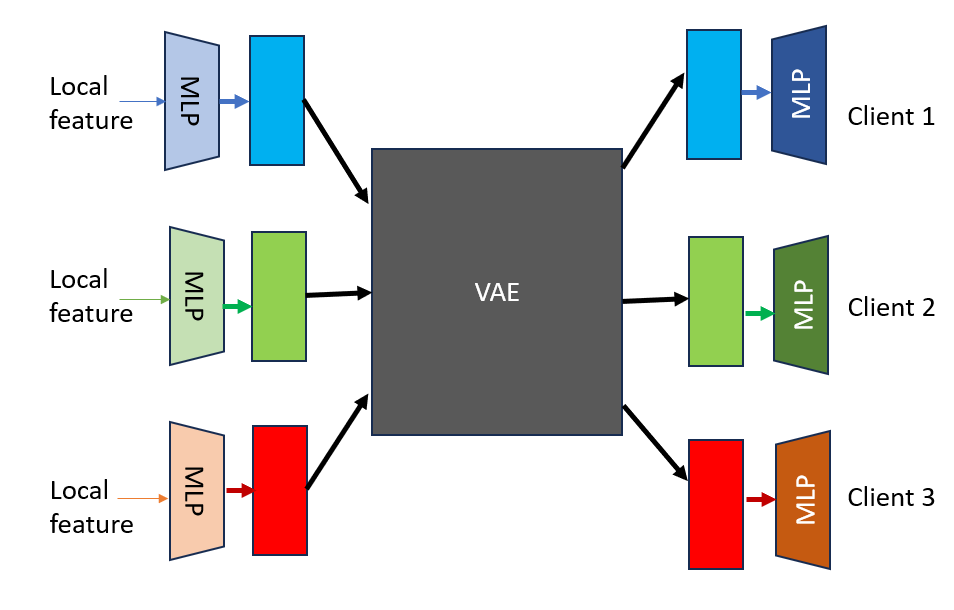

In [5]:
from torch import nn, optim
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


class MLP(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(MLP, self).__init__()
        self.local_out_dim = out_feat
        self.fc1 = nn.Linear(in_feat, out_feat)
        self.fc2 = nn.Linear(out_feat, out_feat)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.dropout(self.act(self.fc2(x)))


class Autoencoder(nn.Module):
    def __init__(self, input_local_models, H=48, H2=32, latent_dim=16):

        # Encoder
        super(Autoencoder, self).__init__()
        self.optimizer = None
        self.criterion = None
        self.in_size = sum(
            [
                input_local_models[i].local_out_dim
                for i in range(len(input_local_models))
            ]
        )
        self.linear1 = nn.Linear(self.in_size, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, self.in_size)
        self.lin_bn6 = nn.BatchNorm1d(num_features=self.in_size)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))

    def forward(self, x):
        concat_outs = torch.cat(x, dim=1)
        mu, logvar = self.encode(concat_outs)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [6]:
class VFL(nn.Module):
    def __init__(self, input_local_models, output_local_models):
        super(VFL, self).__init__()
        self.num_cli = None
        self.cli_features = None
        self.input_local_models = input_local_models
        self.output_local_models = output_local_models
        self.server_model = Autoencoder(self.input_local_models)
        self.input_local_out_sizes = [
            input_local_models[i].local_out_dim for i in range(len(input_local_models))
        ]

    def train_with_settings(
        self, epochs, batch_sz, cli_features, real_data, optimizer, loss_fn
    ):
        self.cli_features = cli_features
        self.optimizer = optimizer
        self.criterion = loss_fn
        train_losses = []

        real = [real_data[:, feats[0] : feats[-1] + 1] for feats in cli_features]
        num_batches = (
            len(real_data) // batch_sz
            if len(real_data) % batch_sz == 0
            else len(real_data) // batch_sz + 1
        )

        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    minibatch_data = [r[int(minibatch * batch_sz) :] for r in real]
                else:
                    minibatch_data = [
                        r[int(minibatch * batch_sz) : int((minibatch + 1) * batch_sz)]
                        for r in real
                    ]

                outs, mu, logvar = self.forward(minibatch_data)
                outs = torch.cat(outs, dim=1)
                minibatch_data = torch.cat(minibatch_data, dim=1)
                loss = self.criterion(outs, minibatch_data, mu, logvar)
                total_loss += loss
                loss.backward()
                self.optimizer.step()

            train_losses.append(total_loss.detach().numpy() / num_batches)
            print(f"Epoch: {epoch} Loss: {train_losses[-1]:.3f}")

        return train_losses

    def forward(self, x):
        x = [
            self.input_local_models[i](x[i])
            for i in range(len(self.input_local_models))
        ]
        x, mu, logvar = self.server_model(x)
        x = torch.split(x, self.input_local_out_sizes, dim=1)
        return (
            [
                self.output_local_models[i](x[i])
                for i in range(len(self.output_local_models))
            ],
            mu,
            logvar,
        )

Epoch: 0 Loss: 2102.624
Epoch: 1 Loss: 2038.887
Epoch: 2 Loss: 2003.481
Epoch: 3 Loss: 1982.986
Epoch: 4 Loss: 1968.829
Epoch: 5 Loss: 1957.950
Epoch: 6 Loss: 1957.250
Epoch: 7 Loss: 1952.368
Epoch: 8 Loss: 1949.235
Epoch: 9 Loss: 1945.677
Epoch: 10 Loss: 1944.628
Epoch: 11 Loss: 1941.730
Epoch: 12 Loss: 1938.320
Epoch: 13 Loss: 1936.012
Epoch: 14 Loss: 1935.854
Epoch: 15 Loss: 1934.375
Epoch: 16 Loss: 1933.120
Epoch: 17 Loss: 1926.850
Epoch: 18 Loss: 1926.470
Epoch: 19 Loss: 1923.669
Epoch: 20 Loss: 1921.695
Epoch: 21 Loss: 1915.307
Epoch: 22 Loss: 1917.856
Epoch: 23 Loss: 1920.588
Epoch: 24 Loss: 1911.571
Epoch: 25 Loss: 1909.248
Epoch: 26 Loss: 1908.921
Epoch: 27 Loss: 1907.138
Epoch: 28 Loss: 1905.012
Epoch: 29 Loss: 1913.280
Epoch: 30 Loss: 1905.846
Epoch: 31 Loss: 1909.233
Epoch: 32 Loss: 1900.261
Epoch: 33 Loss: 1903.694
Epoch: 34 Loss: 1898.648
Epoch: 35 Loss: 1896.293
Epoch: 36 Loss: 1905.737
Epoch: 37 Loss: 1893.573
Epoch: 38 Loss: 1889.637
Epoch: 39 Loss: 1907.132
Epoch: 40 

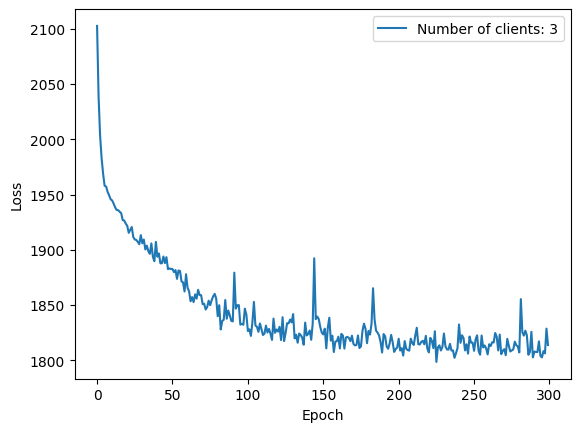

In [7]:
torch.manual_seed(42)
np.random.seed(42)

# Preprocess data
df = pd.read_csv("heart-dataset/heart.csv")
categorical = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
encoded_df = pd.get_dummies(df, columns=categorical)
X = encoded_df.drop("target", axis=1)
y = encoded_df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train.values).long()
y_test = torch.tensor(y_test.values).long()
real_data = torch.concat((X_train, y_train.view(-1, 1)), dim=1)

# Split data among clients
num_clients = 3
features_per_client = (num_clients - 1) * [real_data.shape[1] // num_clients]
features_per_client.append(real_data.shape[1] - sum(features_per_client))
features_per_client = np.array(features_per_client)
all_feature_names = np.array(range(real_data.shape[1]))
client_feature_names = []

start_index = 0
for num_feats in features_per_client:
    feat_names = all_feature_names[start_index : start_index + num_feats]
    client_feature_names.append(feat_names)
    start_index += num_feats

# Define models
outs_per_client = 2
input_local_models = [
    MLP(len(in_feats), outs_per_client * len(in_feats))
    for in_feats in client_feature_names
]
output_local_models = [
    MLP(outs_per_client * len(in_feats), len(in_feats))
    for in_feats in client_feature_names
]

Network = VFL(input_local_models, output_local_models)
optimizer = optim.Adam(Network.parameters(), lr=1e-3)
loss_mse = customLoss()

# Train model and plot losses
EPOCHS = 300
BATCH_SIZE = 64

train_losses = Network.train_with_settings(
    EPOCHS,
    BATCH_SIZE,
    client_feature_names,
    real_data,
    optimizer,
    loss_mse,
)

plot_losses(EPOCHS, train_losses, "Number of clients", num_clients)

### For any questions regarding this assignment, send an email to a.shankar@tudelft.nl